In [1]:
import pandas
import numpy as np
import random
import math
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import time
from collections import Counter
import traceback
from sklearn.utils import shuffle

In [2]:
class adiff:
    """This code is inspired by the var class from from Rasmusbergpalm's github
    https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py"""

    def __init__(self, value, parents=None,ident=None):
        try:
            assert type(value) in {float, int}, "Numbers please"
        except AssertionError:
            print(traceback.format_exc()) 
            print(type(value))           
        self.val = value
        self.gradient = 0.0
        self.parents = parents
        if parents == None:
            self.parents = []
        self.ident=ident

    def backprop(self, value):#this a point where the code is slow and could possibly be optimised
        self.gradient+= value
        for parent, gradient in self.parents:
            parent.backprop(gradient * value)
    def backward(self):
        self.backprop(1.0)

    def __add__(self, o_value):
        n_value = self.val + o_value.val
        return adiff(n_value, [(self, 1.0), (o_value, 1.0)],"add")

    def __mul__(self, o_value):
        n_value = self.val * o_value.val
        return adiff(n_value, [(self, o_value.val), (o_value, self.val)],"mul")

    def __sub__(self, o_value):
        n_value = adiff(self.val - o_value.val, [(self, 1.0), (o_value, 1.0)],"sub")
        return n_value
    
    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return adiff(self.val ** power, [(self, power * self.val ** (power - 1))])
   
    def __truediv__(self, o_value):
        n_value = self.val/o_value.val
        return adiff(n_value,[(self,1.0/o_value.val), (o_value,-self.val/o_value.val**2)],"truediv")

    def __repr__(self):
        return (f"adiff value = {self.val}, parents = {len(self.parents)}, gradient = {self.gradient}, from {self.ident}")

    def e(self):
        n_value=float(np.exp(self.val))
        return adiff(n_value, [(self, n_value)],"e")
    
    def log(self):
        n_value=math.log(self.val+1e-6)
        return adiff(n_value, [(self,1/n_value)])
    
    def relu(self,data):
        return [[adiff(j.val/1,[(j,1.0)],"relu1") if j.val>0 else adiff(0,[(j,0.0)],"relu2") for j in i] for i in data]    

    def softmax(self,data):
        values=data
        sums=[]
        for row in values:
            current_sum = adiff(0.0)
            for value in row:
                current_sum += value.e()
            sums.append(current_sum)
        s_i=[[(item.e()/sums[i]) for item in row] for i,row in enumerate(data)]
        return s_i

    def sigmoid(self, data):
        thing=[]
        for i in data:
            thing2=[]
            for j in i:
                thing2.append(adiff(1.0)/(adiff(1.0)+j.e()))
            thing.append(thing2)
        return thing

In [12]:
class network:
    def __init__(self, layers_info,activate = "sigmoid",alpha=0.0015,gd="stochastic", batch_s=5,epochs=100):
        self.bias = 0.5
        self.epochs=epochs
        self.layers_info = layers_info
        self.Network=[]
        self.activate=activate
        self.alpha=alpha
        self.loss_sum = adiff(9e21)
        self.losses=[]
        self.gd=gd
        self.batch_s=batch_s
        
    def fit(self,x,y):
        self._create(x)#create the network
        self._backprop(y)#fit the network     
    
    def _create(self,input_data):
        for row in range(len(input_data)):#add a column of 1s to add the bias during matrix multiplicaiton
            input_data[row].append(adiff(1.0))
        self.x=input_data #save to self for forward pass

        for l_info in self.layers_info: #create new layers
            new_layer = layer(l_info, len(input_data[1]),self.activate)
            new_layer._calculation(input_data)
            self.Network.append(new_layer)
            input_data = new_layer.next_layer_input
        self.output_layer= layer(6, len(input_data[1]),"softmax")#hardcoded output layer for 6 classes (specific to our classifictatin problem)
        self.output_layer._calculation(input_data)
        self.Network.append(self.output_layer)

    def predict(self,data):
        self._forwardpass(data)
        values=[[item.val for item in row] for row in self.Network[-1].next_layer_input]
        return np.array([row.index(max(row)) for row in values])
    
    def _forwardpass(self,data):
        for l_info in self.Network:
            l_info._calculation(data)
            data=l_info.next_layer_input
            
    def _backprop(self,y_true):
        for i in tqdm(range(self.epochs)):#cross entropy loss here matches the last layer type!!!! so has to be CEL
            self.loss_sum=adiff(0.0)
            rand_int=random.randint(0,len(y_true)-1) 
            rand_ints=np.random.randint(0,len(y_true)-1,self.batch_s)
            #for each option of GD forward pass on the relevant subset of data and calculate the loss sum
            if self.gd=="stochastic":
                self._forwardpass([self.x[rand_int]])
                self.loss_sum+=(self.output_layer.next_layer_input[0][y_true[rand_int]-1]).log()
            
            elif self.gd=="batch":
                batch_x=[self.x[i] for i in rand_ints]
                batch_y=[y_true[i] for i in rand_ints]
                self._forwardpass(batch_x)
                for i,row in enumerate(batch_y):
                    self.loss_sum+=(self.output_layer.next_layer_input[i][row-1]).log()  
            elif:#all data
                self._forwardpass(self.x)
                for i,row in enumerate(y_true): 
                    self.loss_sum+=(self.output_layer.next_layer_input[i][row-1]).log()
            self.loss_sum=adiff(0.0)-self.loss_sum
            self.loss_sum.backward()#find all partial derivatives of the loss function
            self.losses.append(self.loss_sum.val)
            else:
                print("not running correctly due to incorrect activation function name")


            for h,layer in enumerate(self.Network):#change the weights 
                for i,row in enumerate(layer.weights):
                    for j,item in enumerate(row):
                        self.Network[h].weights[i][j]=adiff(item.val-self.alpha*item.gradient)
    
class layer:
    def __init__(self,number_of_neurons, n_prev_neurons,activate):
        self.n = number_of_neurons
        self.weights = [[adiff(float(np.random.normal(0, 0.25, 1))) for i in range(number_of_neurons)] for _ in range(n_prev_neurons+1)]
        #all weights from a normal distribution, only works for a small variance as larger weights break other parts of the code
        #with time we would have liked to look into this further and also have found some more optimal weight initializations                                                   
        self.next_layer_input = None
        self.activate=activate
    
    def activation(self,data):#applies relevant activaiton function
        if self.activate == "ReLU": 
            return adiff.relu(self,data)
        elif self.activate == "sigmoid":
            return  adiff.sigmoid(self,data)
        elif self.activate == "softmax":
            return adiff.softmax(self,data)
        else:
            print("invalid activaiton function name")

    def _dot_llist(self,llist1,llist2):
        # matrix multiplication for when not posible in numpy due to the adiff class                                                   
        dot_product = [[0.0 for i in range(len(llist2[0]))] for j in range(len(llist1))]
        for row in range(len(llist1)):
            for column in range(len(llist2[0])):
                a = llist1[row]
                b = [l2row[column] for l2row in llist2]
                sum_ = adiff(0.0)
                for f in a:
                    for g in b:
                        sum_ += f * g
                dot_product[row][column]=sum_
        return dot_product

    def _calculation(self, data):
        self.next_layer_input = self.activation(self._dot_llist(data,self.weights))

In [4]:
test=pandas.read_csv("../data/df_test.csv")
train=pandas.read_csv("../data/df_train.csv")

In [13]:
def preprocess(data):#relables,normalises,shuffles and splits data into X and y 
    norm = StandardScaler()
    ros = RandomOverSampler(random_state=0)
    mapping={1:1,2:2,3:3,5:4,6:5,7:6}##changes y to be usable in loss funciton
    y=data.loc[:, data.columns == "type"]
    y=np.ravel(y)
    y=np.array([mapping[i]for i in y])
    X=data.loc[:, data.columns != "type"]
    X = norm.fit_transform(X)
    X, y = ros.fit_resample(X, y)
    X=[[adiff(float(j)) for j in i] for i in X]
    X,y=shuffle(X,y)
    return(X,y)
#we need a shuffle here

In [14]:
X,y=preprocess(train)
testingthing=network([3],activate = "sigmoid",alpha=0.015,gd="batch", batch_s=10,epochs=200)
testingthing.fit(X,y)

100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


In [15]:
X_test,y_test=preprocess(test)
testingthing.predict(X_test) #predicted labels

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5])

In [16]:
y_test#real labels 

array([5, 3, 3, 2, 6, 3, 6, 2, 6, 1, 3, 1, 4, 2, 1, 3, 4, 2, 2, 4, 4, 5,
       5, 2, 2, 3, 6, 2, 6, 4, 4, 4, 1, 6, 2, 1, 3, 3, 6, 1, 4, 2, 3, 3,
       6, 5, 1, 6, 3, 5, 1, 3, 1, 6, 2, 1, 5, 6, 2, 1, 5, 3, 2, 6, 2, 5,
       2, 4, 5, 3, 6, 4, 2, 3, 5, 5, 1, 4, 6, 6, 6, 1, 4, 3, 4, 2, 5, 1,
       3, 3, 4, 5, 4, 4, 4, 4, 4, 1, 5, 5, 3, 1, 4, 5, 3, 6, 6, 1, 5, 1,
       5, 2, 1, 6, 2, 4, 5, 1, 5, 4, 1, 6, 5, 3, 5, 2, 5, 3, 2, 6, 1, 2,
       6, 1, 2, 3, 6, 4])

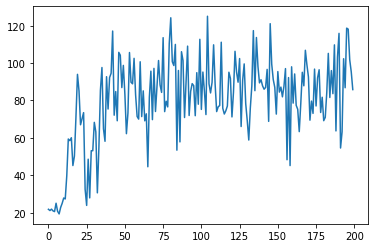

In [17]:
plt.plot([i for i in range(len(testingthing.losses))],testingthing.losses)

In [10]:
testingthing.Network

[<__main__.layer at 0x7f99a164b890>, <__main__.layer at 0x7f99a1650190>]

In [11]:
#https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
#^ for later reference for the cross entropy loss we need to use

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=58866f15-1cff-4fef-9525-5c3070562370' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>